# 2.1 Single component convection using first order upwind

courant = 0.20000


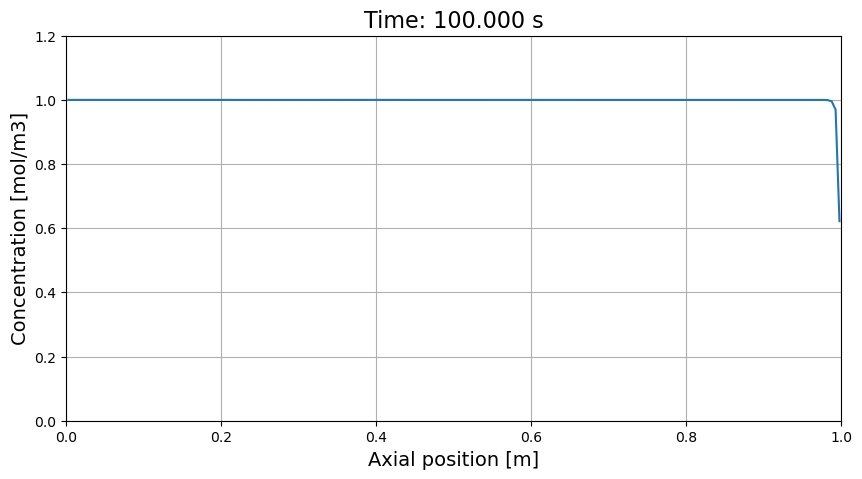

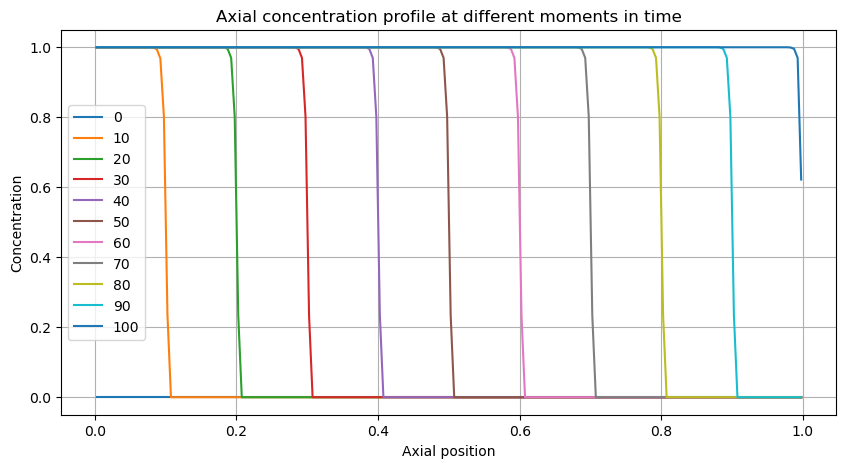

In [1]:
import numpy as np
import matplotlib.pyplot as plt

c0 = 0.0           # initial concentration [mol/m3]
cin = 1.0          # inlet concentration [mol/m3] 
vel = 0.01         # fluid velocity [m/s] 
kr = 1.0           # first order reaction rate constant [1/s]

t_end = 100.0      # end time [s]
dt = 0.1           # time step [s]

x_end = 1.0        # length [m]
nx = 200           # number of grid cells [-] 
dx = x_end/nx      # grid spacing [m]

def conv_flux(c, vel, method='FOU'):
    cf = np.zeros(nx+1)    
    
    match method:
        case 'FOU': # first order upwind
            cf = np.array()
            cf[0] = cin
            cf[1:] = c
        case 'central':  # second order central
            cf[0] = cin
            cf[1:-1] = 0.5*(c[:-1] + c[1:])
            cf[nx] = c[nx-1]
        case 'min-mod': # second order TVD with min-mod limiter
            cf[0] = cin
            cf[1] = c[0]
            cU = c[0:nx-2]
            cD = c[2:nx]
            c_norm_C = (c[1:-1] - cU)/(cD - cU + 1e-40)
            cf[2:-1] = cU + (cD - cU)*(c_norm_C + 0.5*np.maximum(0, 0.5 - np.abs(c_norm_C - 0.5)))
            cf[nx] = c[-1]
        case 'superbee': # second order TVD with superbee limiter
            cf[0] = cin
            cf[1] = c[0]
            cU = c[0:nx-2]
            cD = c[2:nx]
            c_norm_C = (c[1:-1] - cU)/(cD - cU + 1e-40)
            cf[2:-1] = cU + (cD - cU)*(c_norm_C + np.maximum(0, np.minimum(0.5 - np.abs(c_norm_C - 0.5), 0.5*(0.5 + np.abs(c_norm_C - 0.5)))))
            cf[nx] = c[-1]
                        
    conv_flux = vel*(cf[1:] - cf[:-1])/dx
    return conv_flux


xc = np.linspace(0.5*dx, x_end-0.5*dx, num=nx, endpoint=True)
t = 0
c = c0*np.ones(nx)

t_plot = t
c_plot = c.copy()

plt.ion()
fig, ax = plt.subplots(figsize = (10,5))
line = []
line += ax.plot(xc, c)
ax.set_title(f"Time: {t:5.3f} s", fontsize=16)
ax.set_xlabel("Axial position [m]", fontsize=14)
ax.set_ylabel("Concentration [mol/m3]", fontsize=14)
ax.set_xlim(0, x_end)
ax.set_ylim(0, 1.2*cin)
ax.grid()
iplot = 0

t_plot2 = t
c_plot2 = c.copy()
jplot = 0


courant = vel*dt/dx
print(f"{courant = :.5f}")

while True:
    t_old = t
    c_old = c.copy()  
    t += dt
    if t>t_end + 1e-10:
        break

    c = c_old - dt*conv_flux(c, vel, method='superbee')
    
    iplot += 1
    if (iplot % 10 == 0):
        t_plot = np.append(t_plot, t)
        c_plot = np.vstack([c_plot, c.copy()])

        ax.set_title(f"Time: {t:5.3f} s", fontsize=16)
        line[0].set_ydata(c)
        fig.canvas.draw()
        fig.canvas.flush_events()
        iplot = 0
        
    jplot += 1
    if (jplot % 100 == 0):
        t_plot2 = np.append(t_plot2, t)
        c_plot2 = np.vstack([c_plot2, c.copy()])

plt.ioff()       

fig2, ax2 = plt.subplots(figsize = (10,5))
for i in range(len(t_plot2)):
    ax2.plot(xc, c_plot2[i], label=f"{t_plot2[i]:.0f}")
ax2.set_title('Axial concentration profile at different moments in time')
ax2.set_xlabel('Axial position')
ax2.set_ylabel('Concentration')
ax2.legend()
ax2.grid()
plt.show()